In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.preprocessing import OrdinalEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer


from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import FunctionTransformer

# from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv(r"../data/interim/2_feature_engineered/1_base_data.csv")

In [3]:
class CustomOrdinalEncoder(BaseEstimator,TransformerMixin):
    '''
    Converts categories into numbers for KNNImputing
    '''
    
    def __init__(self,feature_name=None):
        self.ord_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=1001)
        self.feature = feature_name
    
    def fit(self,X,y=None):
        na_indices = X[X.isna()].index.values
        not_na_rows = X[X.notna()]
        not_na_np = not_na_rows.to_numpy().reshape(-1,1)
        self.ord_encoder = self.ord_encoder.fit(not_na_np)
        return self
    
    def transform(self,X,y=None):
        na_indices = X[X.isna()].index.values
        not_na_rows = X[X.notna()]
        not_na_np = not_na_rows.to_numpy().reshape(-1,1)
        transformed_data = self.ord_encoder.transform(not_na_np)
        not_na_encode = pd.Series(transformed_data.flatten(),index = not_na_rows.index.values)
        return not_na_encode
    
    def inverse_transform(self,X,y=None):
        col = X.to_numpy().reshape(-1,1)
        return self.ord_encoder.inverse_transform(col)

In [4]:
cat_columns = [
'Self_Employed',
 'Dependents',
 'Gender',
 'Married',
 'Education',
 'Property_Area',
 'Credit_History']

num_columns = ['LoanAmount','ApplicantIncome','TotalApplicantIncome']
# num_columns = ['TotalApplicantIncome']

In [90]:
# X = df[["Credit_History","Property_Area",'TotalApplicantIncome']]
X = df.drop(columns=['Loan_Status'])
y = df['Loan_Status']

In [91]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=df['Loan_Status'],random_state=60,train_size=0.6)

In [92]:
X_train = X_train.sort_index()
y_train = y_train.sort_index()
X_test = X_test.sort_index()
y_test = y_test.sort_index()

In [93]:
X_train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,LoanAmount,Credit_History,Property_Area,TotalApplicantIncome,unknowns
0,Male,No,0,Graduate,No,8.674026,NaN,1.0,Urban,8.674026,1
1,Male,Yes,1,Graduate,No,8.430109,4.852030,1.0,Rural,8.714568,0
2,Male,Yes,0,Graduate,Yes,8.006368,4.189655,1.0,Urban,8.006368,0
7,Male,Yes,3+,Graduate,No,8.018296,5.062595,0.0,Semiurban,8.619750,0
12,Male,Yes,2,Graduate,No,8.030410,5.298317,1.0,Urban,9.321792,0


In [94]:
ordinal_encoders = []

for feature in cat_columns:
    encoder = CustomOrdinalEncoder(feature_name=feature)
    encoder = encoder.fit(X_train[feature])
    ordinal_encoders.append(encoder)
    X_train.loc[:,feature] = encoder.transform(X_train[feature])
    X_test.loc[:,feature] = encoder.transform(X_test[feature])

In [95]:
scaler = MinMaxScaler()
X_train.loc[:,num_columns] = scaler.fit_transform(X_train.loc[:,num_columns])
X_test.loc[:,num_columns] = scaler.transform(X_test.loc[:,num_columns])

In [96]:
imputer = KNNImputer(n_neighbors=1,) #impute with values from nearest neighbour
X_train = pd.DataFrame(imputer.fit_transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test),columns=X_test.columns)

In [97]:
X_train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,LoanAmount,Credit_History,Property_Area,TotalApplicantIncome,unknowns
0,1.0,0.0,0.0,0.0,0.0,0.582270,0.695249,1.0,2.0,0.294755,1.0
1,1.0,1.0,1.0,0.0,0.0,0.543501,0.639957,1.0,0.0,0.305634,0.0
2,1.0,1.0,0.0,0.0,1.0,0.476150,0.480287,1.0,2.0,0.115596,0.0
3,1.0,1.0,3.0,0.0,0.0,0.478046,0.690715,0.0,1.0,0.280191,0.0
4,1.0,1.0,2.0,0.0,0.0,0.479972,0.747537,1.0,2.0,0.468577,0.0


In [98]:
for encoder,feature in zip(ordinal_encoders,cat_columns):
    X_train.loc[:,feature] = encoder.inverse_transform(X_train[feature])
    X_test.loc[:,feature] = encoder.inverse_transform(X_test[feature])

In [99]:
X_train = pd.get_dummies(data=X_train,columns=cat_columns)
X_test = pd.get_dummies(data=X_test,columns=cat_columns)

In [100]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

<AxesSubplot:ylabel='count'>

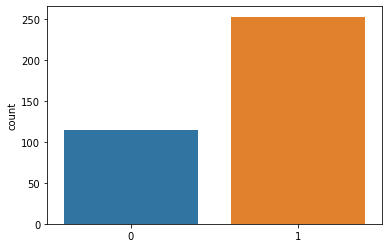

In [101]:
sns.countplot(x=y_train)

In [102]:
sm = SMOTE(random_state=323)
# X_train, y_train = sm.fit_resample(X_train,y_train) #smote worsened the score to 0.82

<AxesSubplot:ylabel='count'>

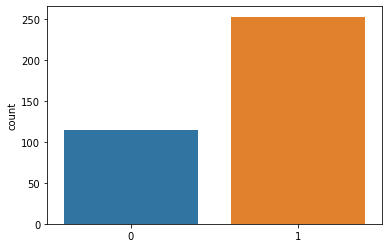

In [103]:
sns.countplot(x=y_train)

# Model

In [104]:
params = {
#     'C':[0.05,0.5,0.8,1,1.5]
}

In [105]:
clf = LogisticRegression(fit_intercept=True,random_state=123,max_iter=1000)
model = GridSearchCV(clf,param_grid=params)

In [106]:
model = model.fit(X_train,y_train)

In [107]:
model.score(X_train,y_train)

0.7961956521739131

In [108]:
# model.score(X_test,y_test)

In [109]:
f1_score(y_test,model.predict(X_test))

0.8639999999999999

In [110]:
f1_score(y_train,model.predict(X_train))

0.8653500897666068

In [10]:
import matplotlib.pyplot as plt

AttributeError: module 'matplotlib' has no attribute 'get_data_path'

In [118]:
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=model, dataset=val_X, model_features=feature_names, feature='Goal Scored')

# plot it
pdp.pdp_plot(pdp_goals, 'Goal Scored')
plt.show()

ModuleNotFoundError: No module named 'pdpbox'

In [111]:
params= {
    "n_estimators" : [20,50,100,150],
    "max_depth" : [2,3,5,6],
}

In [112]:
clf_forest = RandomForestClassifier()
model_forest = GridSearchCV(clf_forest,param_grid=params,cv=4)

In [113]:
model_forest.fit(X_train,y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 3, 5, 6],
                         'n_estimators': [20, 50, 100, 150]})

In [114]:
f1_score(y_train,model_forest.predict(X_train))

0.8648648648648648

In [115]:
f1_score(y_test,model_forest.predict(X_test))

0.8700265251989389

In [116]:
model_forest.best_estimator_

RandomForestClassifier(max_depth=2)

In [81]:
#0.8746, 0.877256
#test train
# 0.87 0.86     property_area, credit_history, totalincome
# 

In [37]:
pd.DataFrame(zip(X_train.columns,model_forest.best_estimator_.feature_importances_)).sort_values(by=[1],ascending=False).rename(columns = {0:"Feature",1:"Score"})

,Feature,Score
19,Credit_History_1.0,0.427144
18,Credit_History_0.0,0.211507
16,Property_Area_Semiurban,0.125483
0,ApplicantIncome,0.062681
15,Property_Area_Rural,0.053380
1,LoanAmount,0.044534
2,TotalApplicantIncome,0.039595
13,Education_Graduate,0.009087
3,Self_Employed_No,0.007726
8,Dependents_3+,0.006897


In [46]:
from sklearn.inspection import permutation_importance
r = permutation_importance(model_forest, X_test, y_test,
                           n_repeats=30,
                           random_state=0)

In [47]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_train.columns[i]:<8}"+"  "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

Credit_History_1.0  0.141 +/- 0.018
Credit_History_0.0  0.034 +/- 0.006


In [48]:
r = permutation_importance(model, X_train, y_train,
                           n_repeats=30,
                           random_state=0)

In [49]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_train.columns[i]:<8}"+"  "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

Credit_History_1.0  0.060 +/- 0.012
Credit_History_0.0  0.060 +/- 0.012
Property_Area_Rural  0.004 +/- 0.002
